In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr

c:\Users\sunitmondal\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import kagglehub
path = kagglehub.dataset_download("farzadnekouei/trash-type-image-dataset")
print("Dataset downloaded to:",path)

Dataset downloaded to: C:\Users\sunitmondal\.cache\kagglehub\datasets\farzadnekouei\trash-type-image-dataset\versions\1


In [2]:
dataset_dir= r"C:\Users\sunitmondal\.cache\kagglehub\datasets\farzadnekouei\trash-type-image-dataset\versions\1\TrashType_Image_Dataset"
image_size = (124, 124)
batch_size = 32
seed = 42

In [3]:
import tensorflow as tf
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [5]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_dat = val_ds.skip(val_batches // 2)
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [6]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


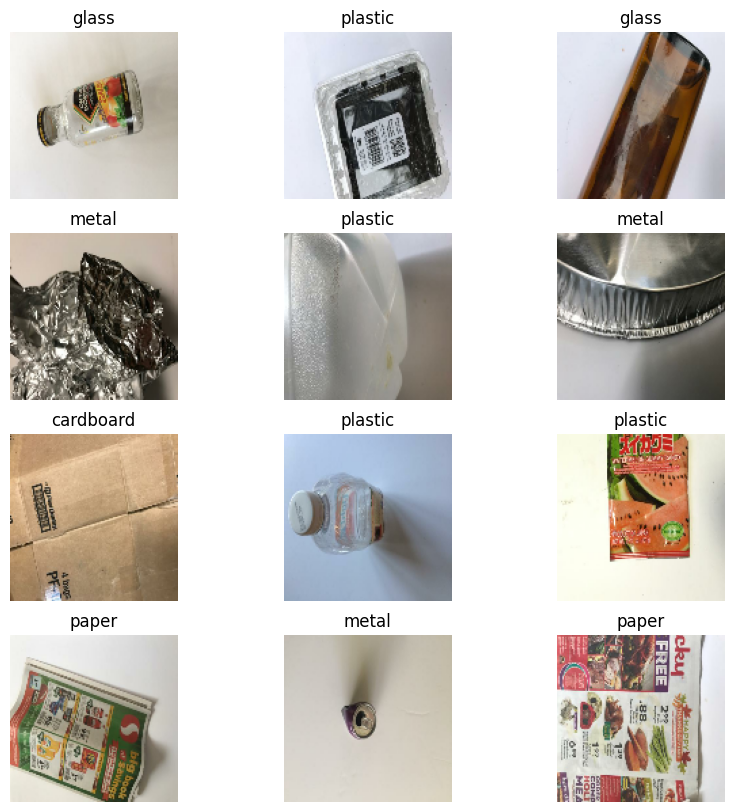

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [8]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)
    return counts

In [9]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [10]:
class_names = train_ds.class_names

# Helper to count class distribution in dataset
def get_distribution(dataset, class_names):
    counts = {k: 0 for k in class_names}
    total = 0

    for images, labels in dataset:
        for label in labels:
            class_name = class_names[int(label)]
            counts[class_name] += 1
            total += 1
    if total==0:
        return counts # Avoid zerodivision error

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)
    return counts

# Compute distributions
train_dist = get_distribution(train_ds,class_names)
val_dist = get_distribution(val_ds,class_names)
test_dist = get_distribution(test_ds,class_names)

# Compute overall distribution from train and val
overall_dist = {}
for k in class_names:
    overall_dist[k]=round((train_dist.get(k,0) + val_dist.get(k,0))/ 2, 2)

# Print results
print("Train Distribution:", train_dist)
print("Validation Distribution:", val_dist)
print("Test Distribution:", test_dist)
print("Overall Distribution:(Train + val Avg)", overall_dist)

Train Distribution: {'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
Validation Distribution: {'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
Test Distribution: {'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
Overall Distribution:(Train + val Avg) {'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


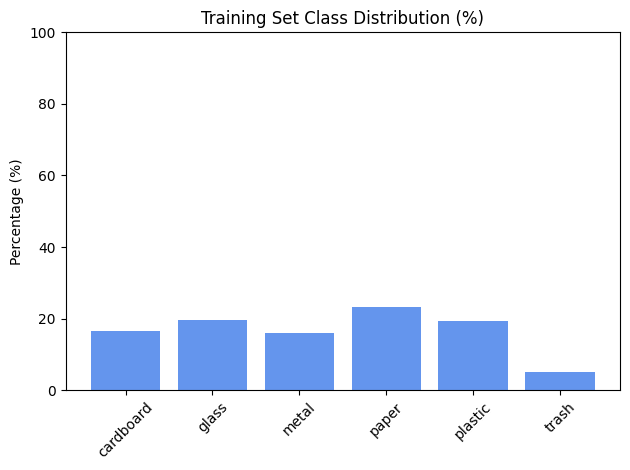

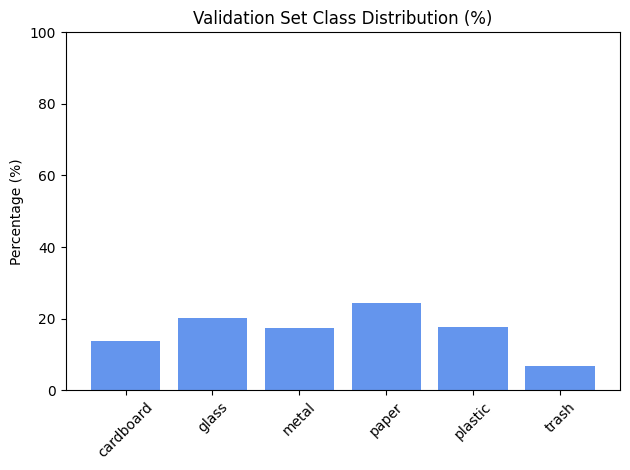

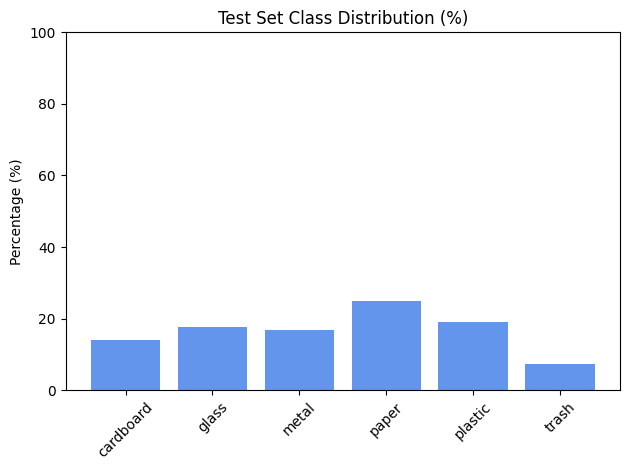

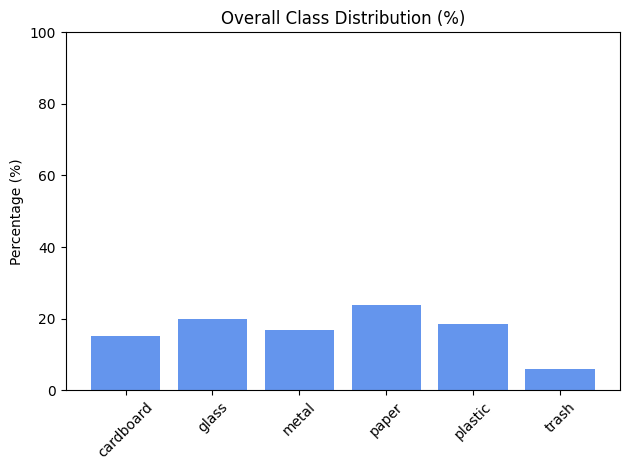

In [11]:
# show visuallisations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [12]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# count class occurences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        if isinstance(label, np.ndarray):
            label=np.argmax(label)
        class_counts[label] += 1
        all_labels.append(label)

# compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced' ,
    classes=np.unique(all_labels),
    y=all_labels
)

# create dictionary mapping class index to weight
class_weights = {i: w for i, w in zip(np.unique(all_labels), class_weights_array)}

In [13]:
# optional: print results
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights: {np.int32(0): np.float64(1.0089820359281436), np.int32(1): np.float64(0.8446115288220551), np.int32(2): np.float64(1.046583850931677), np.int32(3): np.float64(0.7154989384288747), np.int32(4): np.float64(0.8575063613231552), np.int32(5): np.float64(3.2718446601941746)}


In [14]:
# Define data augumentation pipeline
data_augumentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

In [15]:
from tensorflow.keras.applications import MobileNetV3Small
# Load the pretrained MobileNetV3Small model (without the top classification layer)
base_model = MobileNetV3Small(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')

# Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:   # You can adjust this number
    layer.trainable = False

c:\Users\sunitmondal\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\applications\mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [16]:
# Build the final model
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augumentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(6, activation='softmax')   # Change to your number of classes
])

In [17]:
# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy' ,
    metrics=['accuracy']
)

In [18]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',               # Metric to monitor (validation loss here)
    patience=3,                       # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True         # After stopping, restore the model weights from the epoch with the best val_loss
)

In [19]:
# Fix class_weights to reindex from 0
label_mapping = {label: idx for idx, label in enumerate(sorted(set(all_labels)))}
mapped_labels = [label_mapping[label] for label in all_labels]

from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(label_mapping)),
    y=mapped_labels
)

class_weights = {i: w for i, w in enumerate(class_weights_array)}

In [20]:
# Summary (Optional but useful)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 4, 4, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         3,462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 942,582 (3.60 MB)

 Trainable params: 758,662 (2.89 MB)

 Non-trainable params: 183,920 (718.44 KB)

In [21]:
base_model.summary()  # Print the architecture summary of the base model

Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 124, 124,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 124, 124,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 62, 62,    │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 62, 62,    │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 62, 62,    │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 63, 63,    │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 31, 31,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 31, 31,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 31, 31,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 31, 31,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 31, 31,    │        256 │ expanded_conv_sq

 Total params: 939,120 (3.58 MB)

 Trainable params: 755,200 (2.88 MB)

 Non-trainable params: 183,920 (718.44 KB)

Epoch 1/12
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9712 - loss: 0.0995 - val_accuracy: 0.8851 - val_loss: 0.4212
Epoch 2/12
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9674 - loss: 0.1062 - val_accuracy: 0.8832 - val_loss: 0.4188
Epoch 3/12
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9662 - loss: 0.1077 - val_accuracy: 0.8772 - val_loss: 0.4531
Epoch 4/12
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9579 - loss: 0.1300 - val_accuracy: 0.8733 - val_loss: 0.4489
Epoch 5/12
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9644 - loss: 0.1086 - val_accuracy: 0.8713 - val_loss: 0.4614
Epoch 6/12
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.9819 - loss: 0.0660 - val_accuracy: 0.8772 - val_loss: 0.4660
Epoch 7/12
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.9728 - loss: 0.0887 - val_accuracy: 0.8752 - val_loss: 0.4426
Epoch 8/12
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.9859 - loss: 0.0680 - val_accuracy: 0.8792 - v

Text(0.5, 1.0, 'Training vs Validation Loss')

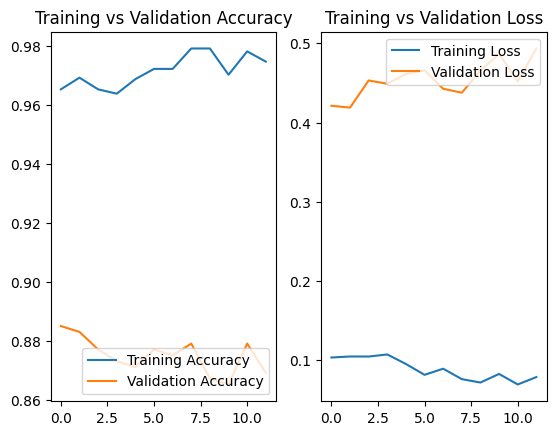

In [29]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12
)

acc = history.history['accuracy']          # Extract training accuracy from history
val_acc = history.history['val_accuracy']  # Extract validation accuracy from history
loss = history.history['loss']             # Extract training loss from history
val_loss = history.history['val_loss']     # Extract validation loss from history

epochs_range = range(len(acc))          # Define range for epochs based on accuracy length

plt.Figure(figsize=(10,8))              # Set overall figure size for visualization

plt.subplot(1,2,1)                      # Create first subplot (1 row, 2 columns, position 1)
plt.plot(epochs_range, acc, label='Training Accuracy')        # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # Plot validation accuracy
plt.legend(loc='lower right')                                 # Place legend in lower-right corner
plt.title('Training vs Validation Accuracy')                  # Add title for accuracy plot

plt.subplot(1,2,2)                      # Create second subplot (1 row, 2 columns, position 2)
plt.plot(epochs_range, loss, label='Training Loss')            # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')      # Plot validation loss
plt.legend(loc='upper right')                                  # Place legend in upper-right corner
plt.title('Training vs Validation Loss')                       # Add title for loss plot

In [31]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8924 - loss: 0.4949
Test accuracy is0.8672, Test loss is 0.5433


In [33]:
# Extract true labels from all batches in the test dataset
y_true = np.concatenate( [y.numpy() for x, y in test_ds_eval], axis=0)    # Convert Tensor labels to Numpy array and concatenate them

# Get predictions as probabilities from the model
y_pred_probs = model.predict(test_ds_eval)     # Predict class probabilities for each sample in the test dataset

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)       # Select the class with the highest probability for each sample

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)          # Generate confusion matrix comparing true labels to predicted labels

# Print metrics to assess model performance
print(cm)             # Display confusion matrix
print(classification_report(y_true, y_pred))    # Print precision, recall, and F1-score for each class

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step
[[31  0  1  6  0  0]
 [ 0 43  4  0  2  0]
 [ 0  1 46  0  1  1]
 [ 1  0  1 58  1  0]
 [ 0  0  1  0 39  1]
 [ 1  0  1  2  0 14]]
              precision    recall  f1-score   support

           0       0.94      0.82      0.87        38
           1       0.98      0.88      0.92        49
           2       0.85      0.94      0.89        49
           3       0.88      0.95      0.91        61
           4       0.91      0.95      0.93        41
           5       0.88      0.78      0.82        18

    accuracy                           0.90       256
   macro avg       0.90      0.89      0.89       256
weighted avg       0.91      0.90      0.90       256



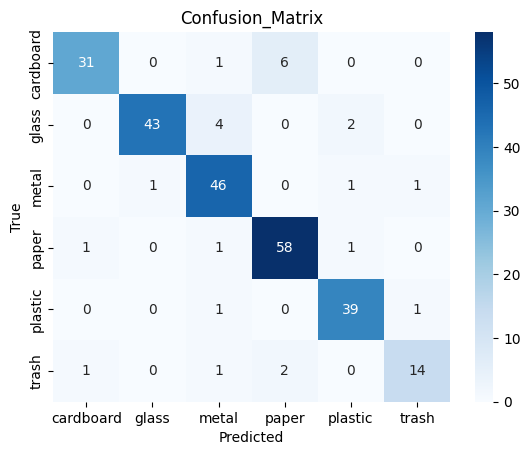

In [36]:
plt.Figure(figsize=(10,8))    # Set figure size for better visualization

sns.heatmap(cm, annot=True, fmt='d',          # Create heatmap using confusion matrix
            xticklabels=class_names,          # Set class names for x-axis (predicted labels)
            yticklabels=class_names,          # Set class names for y-axis (true labels)
            cmap='Blues')                     # Use a blue colormap for better contrast

plt.xlabel('Predicted')   # Label x-axis as Predicted classes
plt.ylabel('True')        # Label y-axis as True classes
plt.title('Confusion_Matrix')    # Add title to the heatmap
plt.show()          # Display the plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


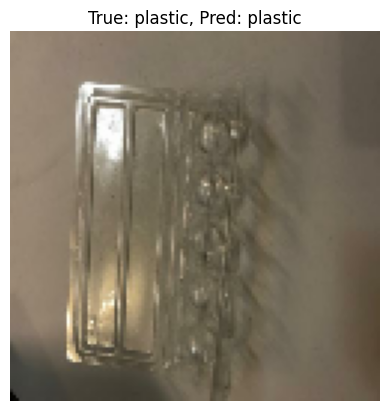

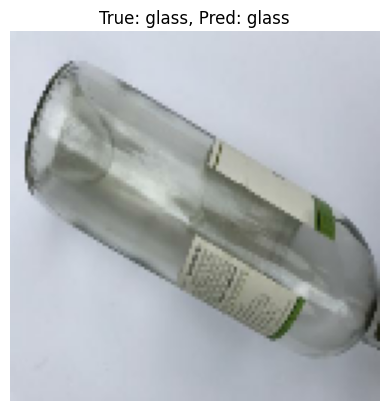

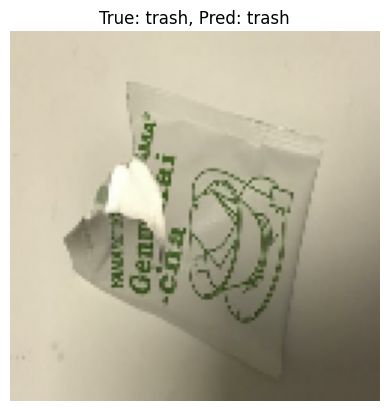

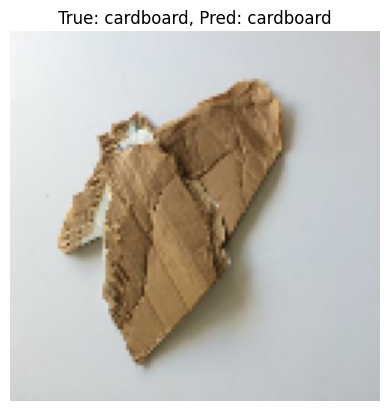

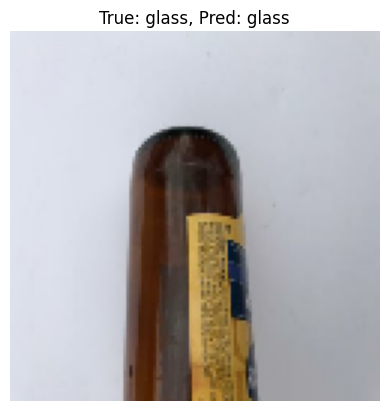

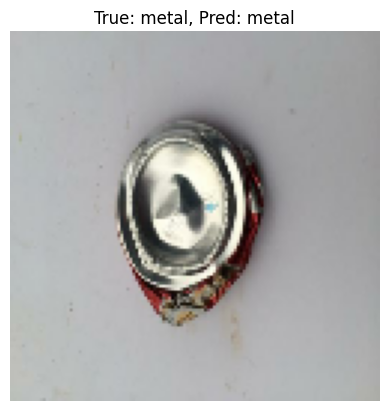

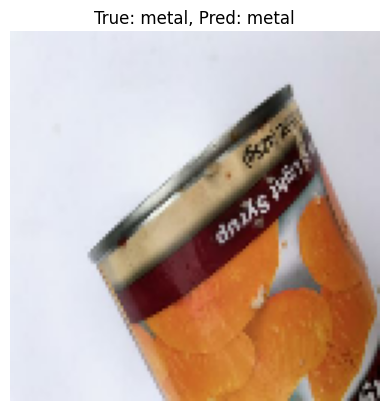

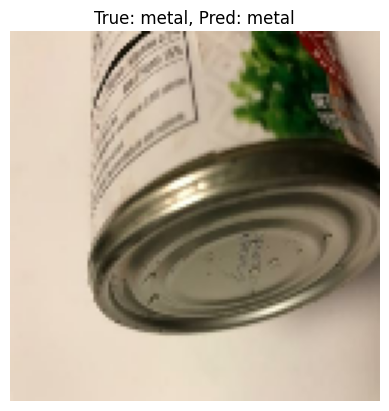

In [37]:
# Extract class names from the training dataset
class_names = train_ds.class_names

# Take one batch of images and labels from the test dataset for evaluation
for images, labels in test_ds_eval.take(1):

    # Generate predictions for the batch of images
    predictions = model.predict(images)

    # Get the predicted class index for each image
    pred_labels = tf.argmax(predictions, axis=1)

    # Loop through the first 8 images in the batch
    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))      # Convert and display image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")   # Show actual and predicted class
        plt.axis("off")    # Hide axes for better visualization
        plt.show()      # Display the image with title

In [ ]:
# Save model in keras format with architecture, weights, and training configuration
model.save('MobileNet.keras')

# Load your keras model
model = tf.keras.models.load_model('MobileNet.keras')

In [ ]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

In [41]:
def classify_image(img):
    # Resize image to 124x124 pixels (Note: Comment says 128x128, but code resizes to 124x124)
    img = img.resize((124, 124))

    # Convert image to a Numpy array with float32 dtype
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)

    # Expand dimentions to matcg model input shape (adds a batch dimension)
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction using the trained model
    prediction = model.predict(img_array)

    # Get the index of the highest predicted probability
    predicted_class_index = np.argmax(prediction)

    # Map the predicted index to its corresponding class name
    predicted_class_name = class_names[predicted_class_index]

    # Extract confidence score (probability of the predicted class)
    confidence = prediction[0][predicted_class_index]

    # Return formatted prediction result with confidence score
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"

In [42]:
iface = gr.Interface(
    fn=classify_image,   # Function to classify image using the trained model
    inputs=gr.Image(type="pil"),
    outputs="text"   # Outputs prediction as text
)

# Launch the interface
iface.launch()      # Start the Gradio interface for user interaction

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
